In [1]:
### configuration: 
### pyspark --driver-memory 4G
### MNIST DATA: https://pjreddie.com/projects/mnist-in-csv/


from numpy import array
from math import sqrt
import numpy as np
import csv
from matplotlib import pyplot as plt
from PIL import Image

import pyspark 
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark import SparkFiles
from pyspark import SparkContext

In [2]:
# Load and parse the data
mnist = sc.textFile("mnist_train.csv")
mnistrdd_temp = mnist.map(lambda line: array([int(x) for x in line.split(',')]))
mnistrdd = mnistrdd_temp.map(lambda line: np.delete(line, 0))

# test:
#print(mnistrdd.collect())

In [3]:
# Build the model (cluster the data)
clusters = KMeans.train(mnistrdd, 10, maxIterations= 10000, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = mnistrdd.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "model/KMeansModel")
sameModel = KMeansModel.load(sc, "model/KMeansModel")

# get centers
centers = clusters.clusterCenters

Within Set Sum of Squared Error = 94187135.96633169


In [4]:
# output as csv
filepath = "data/KMNIST_centroids.csv"

with open(filepath, 'w') as output:
    writer = csv.writer(output, lineterminator="\n")
    writer.writerows(centers)

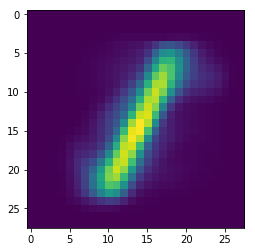

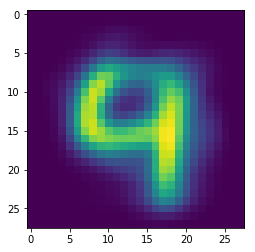

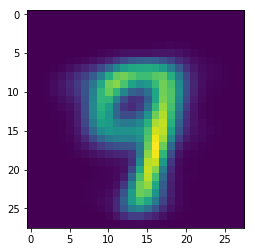

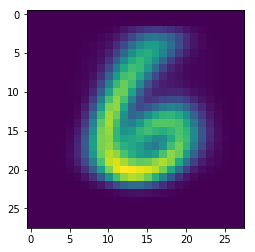

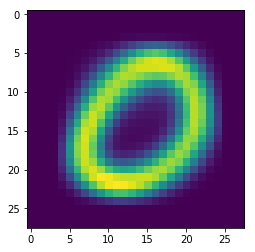

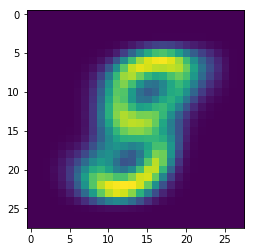

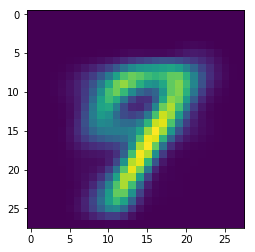

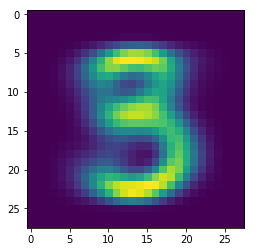

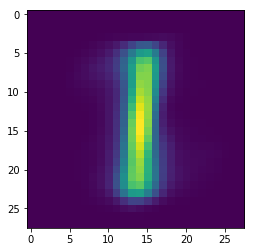

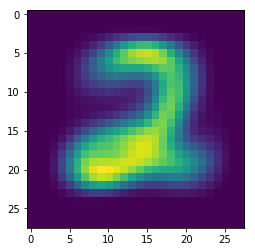

In [5]:
data = np.genfromtxt('data/KMNIST_centroids.csv', delimiter=',')

# plot the 10 centroids
for x in range (0,len(data)):
    centroid = np.reshape(data[x], (28,28))
    plt.imshow(centroid, interpolation='nearest')
    plt.show()
    im = Image.fromarray(centroid)
    if im.mode != 'RGB':
        im_rgb = im.convert('RGB')
    im_rgb.save("center"+str(x)+".png")